In [1]:
import os
print (os.environ['CONDA_DEFAULT_ENV'])  #check if the notebook is using the correct environment

ea_work


In [2]:
import requests
import datetime as dt 
import pandas as pd
import geopandas
import shapely

/home/liangm/.conda/envs/ea_work/lib/python3.7/site-packages/geopandas/_compat.py:53: UserWarning: The installed version of PyGEOS is too old (0.6 installed, 0.8 required), and thus GeoPandas will not use PyGEOS.
  UserWarning,


In [4]:
doi ="10.3334/ORNLDAAC/2056"  #version 2.1 published in 03/17/2021
# CMR API base url
cmrurl='https://cmr.earthdata.nasa.gov/search/' 

doisearch = cmrurl + 'collections.json?doi=' + doi
concept_id = requests.get(doisearch).json()['feed']['entry'][0]['id']
print(concept_id)


C2237824918-ORNL_CLOUD


In [3]:
import os
cwd = os.getcwd()
print(cwd)
from glob import glob
from os import path
import os
print (os.environ['CONDA_DEFAULT_ENV'])

/gpfs/data1/duncansongp/amberliang/EA_data
ea_work


# method 1 spatial query with a bbox

/home/liangm/.conda/envs/ea_work/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


                                                                                                    geometry
0  POLYGON ((37.57800 12.07800, 41.54800 12.07800, 41.54800 15.39000, 37.57800 15.39000, 37.57800 12.07800))


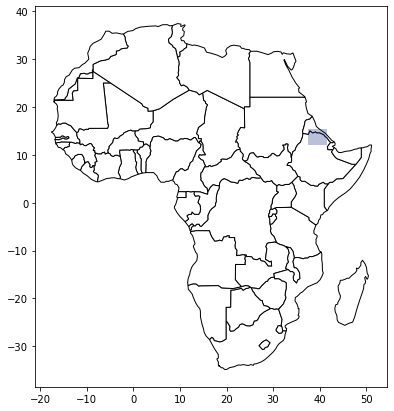

In [11]:
#bbox for east africa
bound =  [37.5780000000000030,12.0779999999999994, 41.5480000000000018,15.3900000000000006]
#[38.4970619714351727,-16.7697862899804164, 38.7881746031181294,-16.5541417963127913]
#[28 ,-12, 48, 15]  #w, s, e, n


lat_point_list = [50.854457, 52.518172, 50.072651, 48.853033, 50.854457]
lon_point_list = [4.377184, 13.407759, 14.435935, 2.349553, 4.377184]

from shapely.geometry import Polygon
from shapely.ops import orient
import matplotlib
polygon_geom = Polygon(zip([37.5780000000000030,37.5780000000000030, 41.5480000000000018,41.5480000000000018, 37.5780000000000030],
                            [12.0779999999999994, 15.3900000000000006,15.3900000000000006,12.0779999999999994, 12.0779999999999994]))
# Polygon(zip([38.4970619714351727, 38.4970619714351727, 38.7881746031181294, 38.7881746031181294, 38.4970619714351727], 
#                            [-16.7697862899804164,-16.5541417963127913, -16.5541417963127913, -16.7697862899804164, -16.7697862899804164]))
#Polygon(zip([28, 28, 48, 48, 28], [-12,15, 15, -12, -12]))
crs = {'init': 'epsg:4326'}
polygon = geopandas.GeoDataFrame(index=[0], crs=crs, geometry=[polygon_geom])   
polygon.geometry = polygon.geometry.apply(orient, args=(1,))
print(polygon)


#temporal extents
start_date= dt.datetime(2019, 4, 17)
end_date= dt.datetime(2021, 12, 31)

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
base = world[world.continent == 'Africa'].plot(color='white', edgecolor='black', figsize  = (7, 7))
ax= polygon.plot(ax=base, color=(0.1, 0.2, 0.5, 0.3))

In [12]:
import pandas as pd
from shapely.geometry import MultiPolygon, Polygon, box

# CMR formatted start and end times
dt_format = '%Y-%m-%dT%H:%M:%SZ'
temporal_str = start_date.strftime(dt_format) + ',' + end_date.strftime(dt_format)

# CMR formatted bounding box
bound_str = ','.join(map(str, bound))
print(bound_str)

page_num = 1
page_size = 2000 # CMR page size limit

granule_arr = []

while True:
    
    # defining parameters
    cmr_param = {
        "collection_concept_id": concept_id, 
        "page_size": page_size,
        "page_num": page_num,
        "temporal": temporal_str,
        "bounding_box[]": bound_str
    }
    
    granulesearch = cmrurl + 'granules.json'

    response = requests.get(granulesearch, params=cmr_param)
    granules = response.json()['feed']['entry']
    
    if granules:
        for g in granules:
            granule_url = ''
            granule_poly = ''
            
            # read file size
            granule_size = float(g['granule_size'])
            
            # reading bounding geometries
            if 'polygons' in g:
                
                polygons= g['polygons']
                multipolygons = []
                for poly in polygons:
                    
                    i=iter(poly[0].split (" "))
                   
                    ltln = list(map(" ".join,zip(i,i)))
                    multipolygons.append(Polygon([[float(p.split(" ")[1]), float(p.split(" ")[0])] for p in ltln]))
                granule_poly = MultiPolygon(multipolygons)
            
            # Get URL to HDF5 files
            for links in g['links']:
                if 'title' in links and links['title'].startswith('Download') \
                and links['title'].endswith('.h5'):
                    granule_url = links['href']
            granule_arr.append([granule_url, granule_size, granule_poly])
               
        page_num += 1
    else: 
        break

37.578,12.078,41.548,15.39


In [13]:
# adding bound as the last row into the dataframe
# we will use this later in the plot
b = list(bound)
granule_arr.append(['bound', 0, box(b[0], b[1], b[2], b[3])]) 

# creating a pandas dataframe
l4adf = pd.DataFrame(granule_arr, columns=["granule_url", "granule_size", "granule_poly"])

# Drop granules with empty geometry
l4adf = l4adf[l4adf['granule_poly'] != '']

print ("Total granules found: ", len(l4adf.index)-1)
print ("Total file size (MB): ", l4adf['granule_size'].sum())

Total granules found:  521
Total file size (MB):  174290.739605


In [14]:
pd.options.display.max_colwidth = 200
l4adf.tail()["granule_url"].iloc[[3]]


520    https://data.ornldaac.earthdata.nasa.gov/protected/gedi/GEDI_L4A_AGB_Density_V2_1/data/GEDI04_A_2021363213259_O17261_02_T05518_02_002_02_V002.h5
Name: granule_url, dtype: object

In [15]:
# drop duplicate URLs if any
l4a_granules = l4adf[:-1].drop_duplicates(subset=['granule_url'])
l4a_granules.to_csv('desa_tile4_l4a_granules_1221_7172023.txt', columns = ['granule_url'], index=False, header = False)

#l4a_granules.to_csv('EA_data/ea_all_granules_2021327.txt', columns = ['granule_url'], index=False, header = False)
print( len(l4adf.index)-1 )
print(len(l4a_granules))

521
521


(11.078, 16.39)

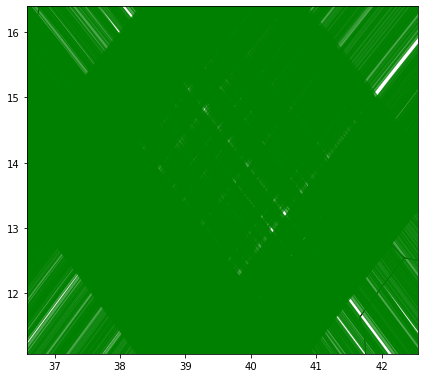

In [16]:
import geopandas
gdf = geopandas.GeoDataFrame(l4adf, geometry=l4adf.granule_poly)
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
base = world.plot(color='white', edgecolor='black', figsize  = (7, 7))

# last row contains the bounding box (Red)
ax= gdf[-1:].plot(ax=base, color='white', edgecolor='red', alpha=0.5)

# all but the last row contains granule bounding geometry (Green)
ax= gdf[:-1].plot(ax=base, color='green', edgecolor='green', alpha=0.7)

minx, miny, maxx, maxy = gdf[-1:].geometry.total_bounds
ax.set_xlim(minx-1, maxx+1)
ax.set_ylim(miny-1, maxy+1)

# method II: use the ea shapefile to download data

In [6]:
amapa

NameError: name 'amapa' is not defined

In [4]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from shapely.ops import orient


world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

0    MULTIPOLYGON (((-120.42586 35.40173, -120.4259...
Name: geometry, dtype: geometry


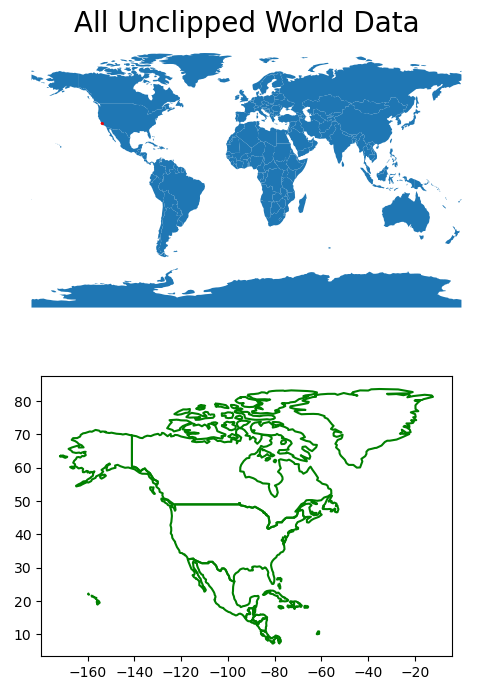

In [5]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from shapely.ops import orient


world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

# Create a subset of the world data that is just the South American continent
south_america = world[world["continent"] == "North America"]

# list_of_names=[1]
# amapa0 = geopandas.read_file("EA_data/kenya.geojson")# amapa= amapa0.query('OBJECTID in @list_of_names')
# amapa=amapa0.dissolve()
# amapa.geometry = amapa.convex_hull
# amapa.geometry = amapa.geometry.apply(orient, args=(1,))
# print(amapa.geometry)

amapa = gpd.read_file("ca_fire/test_fuel_reduction_ssite_buffer.geojson")   #gpd.read_file("AOI/tile168063.geojson")    #Dodoma/Dodoma_merged4326.geojson")
amapa.geometry = amapa.geometry.apply(orient, args=(1,))
print(amapa.geometry)


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
world.plot(ax=ax1)
amapa.boundary.plot(ax=ax1, color="red")
south_america.boundary.plot(ax=ax2, color="green")
ax1.set_title("All Unclipped World Data", fontsize=20)
ax1.set_axis_off()
plt.show()



In [6]:
# amapa=ea_countries
# print(amapa)
# amapa=poly_gdf
print(amapa.geometry)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
base = world[world.continent == 'Europe'].plot(color='white', edgecolor='black', figsize  = (7, 7))
ax= amapa.plot(ax=base, color='red')

0    MULTIPOLYGON (((-120.42586 35.40173, -120.4259...
Name: geometry, dtype: geometry


In [7]:
import requests
from shapely.geometry import MultiPolygon, Polygon
import pandas as pd

doi = '10.3334/ORNLDAAC/2056'# GEDI L4A DOI 

start_date= dt.datetime(2019, 4, 17)
# start_date= dt.datetime(2019, 1, 1)
end_date= dt.datetime(2023, 3, 31)
dt_format = '%Y-%m-%dT%H:%M:%SZ'
temporal_str = start_date.strftime(dt_format) + ',' + end_date.strftime(dt_format)



# CMR API base url
cmrurl='https://cmr.earthdata.nasa.gov/search/' 

doisearch = cmrurl + 'collections.json?doi=' + doi
concept_id = requests.get(doisearch).json()['feed']['entry'][0]['id']

geojson = {"shapefile": ("amapa.geojson", amapa.geometry.to_json(), "application/geo+json")}

page_num = 1
page_size = 2000 # CMR page size limit

granule_arr = []

concept_ids = 'C1908348134-LPDAAC_ECS'

while True:
    
     # defining parameters
    cmr_param = {
        "collection_concept_id": concept_id, 
        "page_size": page_size,
        "page_num": page_num,
         "temporal": temporal_str,
        "simplify-shapefile": 'true' # this is needed to bypass 5000 coordinates limit of CMR
    }
    
    granulesearch = cmrurl + 'granules.json'
    response = requests.post(granulesearch, data=cmr_param, files=geojson)
    print(response.json())
    granules = response.json()['feed']['entry']
       
    if granules:
        for g in granules:
            granule_url = ''
            granule_poly = ''
                       
            # read file size
            granule_size = float(g['granule_size'])
    
            # reading bounding geometries
            if 'polygons' in g:
                polygons= g['polygons']
                multipolygons = []
                for poly in polygons:
                    i=iter(poly[0].split (" "))
                    ltln = list(map(" ".join,zip(i,i)))
                    multipolygons.append(Polygon([[float(p.split(" ")[1]), float(p.split(" ")[0])] for p in ltln]))
                granule_poly = MultiPolygon(multipolygons)
            
            # Get URL to HDF5 files
            for links in g['links']:
                if 'title' in links and links['title'].startswith('Download') \
                and links['title'].endswith('.h5'):
                    granule_url = links['href']
            granule_arr.append([granule_url, granule_size, granule_poly])
               
        page_num += 1
    else: 
        break



{'feed': {'updated': '2024-08-09T15:21:14.672Z', 'id': 'https://cmr.earthdata.nasa.gov:443/search/granules.json', 'title': 'ECHO granule metadata', 'entry': [{'time_start': '2019-04-18T16:16:32.000Z', 'updated': '2023-11-06T16:53:18.000Z', 'dataset_id': 'GEDI L4A Footprint Level Aboveground Biomass Density, Version 2.1', 'data_center': 'ORNL_CLOUD', 'title': 'GEDI_L4A_AGB_Density_V2_1.GEDI04_A_2019108154705_O01969_02_T03766_02_002_02_V002.h5', 'coordinate_system': 'GEODETIC', 'day_night_flag': 'BOTH', 'time_end': '2019-04-18T16:33:09.000Z', 'id': 'G2613773788-ORNL_CLOUD', 'original_format': 'ECHO10', 'granule_size': '225.307761', 'browse_flag': False, 'polygons': [['19.8752422 -137.0616302 22.7887173 -134.5366364 25.6493874 -131.8932953 28.4486485 -129.1105957 31.1768074 -126.1651535 33.8192711 -123.0347519 36.3621635 -119.6951141 38.7886963 -116.1204529 41.0810356 -112.2846527 43.2173462 -108.1659012 45.1748123 -103.7457809 46.9277 -99.0130844 48.4495239 -93.9681091 49.7136459 -88.626

{'feed': {'updated': '2024-08-09T15:21:16.432Z', 'id': 'https://cmr.earthdata.nasa.gov:443/search/granules.json', 'title': 'ECHO granule metadata', 'entry': []}}


In [8]:
# adding bound as the last row into the dataframe
# we will use this later in the plot
granule_arr.append(['amapa', 0, amapa.geometry.item() ]) 

# creating a pandas dataframe
l4adf = pd.DataFrame(granule_arr, columns=["granule_url", "granule_size", "granule_poly"])

# Drop granules with empty geometry
l4adf = l4adf[l4adf['granule_poly'] != '']

print ("Total granules found: ", len(l4adf.index)-1 )
print ("Total file size (MB): ", l4adf['granule_size'].sum())

Total granules found:  96
Total file size (MB):  20859.480153


In [40]:
l4adf.tail()

,granule_url,granule_size,granule_poly
1936,https://data.ornldaac.earthdata.nasa.gov/prote...,243.861996,"(POLYGON ((-136.588913 19.3319912, -134.092514..."
1937,https://data.ornldaac.earthdata.nasa.gov/prote...,255.554055,"(POLYGON ((-132.5270844 16.9505482, -130.10842..."
1938,https://data.ornldaac.earthdata.nasa.gov/prote...,172.850266,"(POLYGON ((-142.9741821 25.3588295, -140.21376..."
1939,https://data.ornldaac.earthdata.nasa.gov/prote...,161.178484,"(POLYGON ((-147.8969269 48.7064018, -142.83485..."
1940,amapa,0.000000,(POLYGON ((-117.3209509263148 32.6898517491605...


In [9]:
import geopandas
gdf = geopandas.GeoDataFrame(l4adf, geometry=l4adf.granule_poly)
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
base = world.plot(color='white', edgecolor='black', figsize  = (7, 7))

# last row contains the bounding box (Red)
ax= gdf[-1:].plot(ax=base, color='white', edgecolor='red', alpha=0.5)

# all but the last row contains granule bounding geometry (Green)
ax= gdf[:-1].plot(ax=base, color='green', edgecolor='green', alpha=0.7)

minx, miny, maxx, maxy = gdf[-1:].geometry.total_bounds
ax.set_xlim(minx-1, maxx+1)
ax.set_ylim(miny-1, maxy+1)

(34.11681377590224, 36.76442657994256)

download the granules to a text file     

In [10]:
# drop duplicate URLs if any
l4a_granules = l4adf[:-1].drop_duplicates(subset=['granule_url'])
#l4a_granules.to_csv('EA_data/ea_granules_2021327.txt', columns = ['granule_url'], index=False, header = False)  #all ea links

# l4a_granules.to_csv('testtile168063_l4a_granules_2019-2022.txt', columns = ['granule_url'], index=False, header = False)  #kibale linkes
l4a_granules.to_csv('test_FuelReduct_buff_l4a_2019-23.txt', columns = ['granule_url'], index=False, header = False)  #kibale linkes

print( len(l4adf.index)-1 )
print(len(l4a_granules))

96
96
